## Aufgaben 
+ Erstellen Sie eine kurze explorative Datenanalyse zur train.csv um erste Einsichten zu gewinnen. Auffälligkeiten bitte in kurzer Form im Markdown notieren.
+ Erstellen Sie ein Pytorch-Dataset, in dem Sie die Bilder und tabularen Daten zusammenfassen. Das Dataset wird drei(!) Dinge zurückgeben (das Bild, die passende Zeile aus dem Dataframe sowie das Target)
+ Erstellen Sie ein Pytorch-Modell, welches ausschließlich aufgrund der Bilder klassifiziert.
+ Testen Sie das Modell mit einem Sample
+ Trainieren Sie das Modell und geben Sie die Accuracy sowie den F1-Score aus
+ Kombinieren Sie nun tabulare Daten und Bilder: Erstellen Sie ein weiteres Pytorch-Modell welches das Bild UND die tabularen Daten verarbeiten kann. (Tipp: die Forward-Methode bekommt hier das Bild sowie die passende Zeile aus dem Dataframe übergeben, es handelt sich hier um ein Multimodales-Modell)
+ Halten Sie ihr Vorgehen in Form eines (kurzen, gerne auch stichwortartigen) Protokolls im Markdown fest. Gehen Sie auch auf Probleme und Sackgassen ein!
+ Beide Modelle sollen eine submission erstellen!

In [2]:
import pandas as pd
from helper import * # eigene funktionen aus externer py-Datei
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import transforms
import PIL
import PIL.Image
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.read_csv("train.csv")

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [4]:
# Traningsdaten laden und transformieren
train_df, anatom_site_map, _ = load_and_transform("train.csv")
train_df

,image_name,gender,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,1,45,0,0.0
1,ISIC_0015719,0,45,1,0.0
2,ISIC_0052212,0,50,2,0.0
3,ISIC_0068279,0,45,0,0.0
4,ISIC_0074268,0,55,1,0.0
...,...,...,...,...,...
33121,ISIC_9999134,1,50,3,0.0
33122,ISIC_9999320,1,65,3,0.0
33123,ISIC_9999515,1,20,2,0.0
33124,ISIC_9999666,1,50,2,0.0


# EDA

#### Bei Menschen mit welchem Alter werden am häufigsten bösartige Befälle fesgestellt? -> ca. 65 Jahre

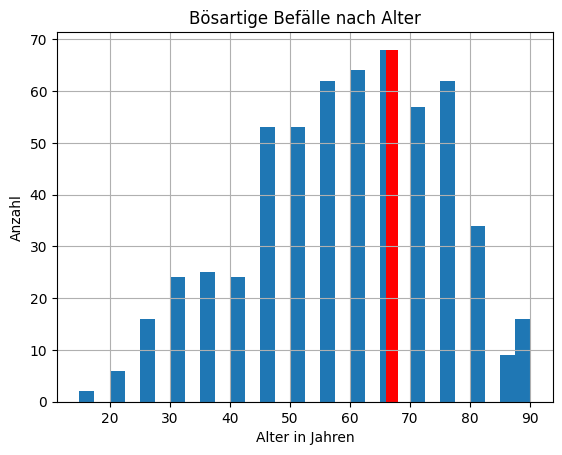

In [5]:
pos_age = train_df[train_df["target"] == 1]["age_approx"]
max_age = train_df[train_df["target"] == 1]["age_approx"].value_counts()

plt.hist(pos_age, bins=30)
plt.bar(x=pos_age.value_counts().max()-1, height=max_age.max(), color="red", width=2)
plt.grid(True)
plt.xlabel("Alter in Jahren")
plt.ylabel("Anzahl")
plt.title("Bösartige Befälle nach Alter")
plt.show()

### Korrelationen

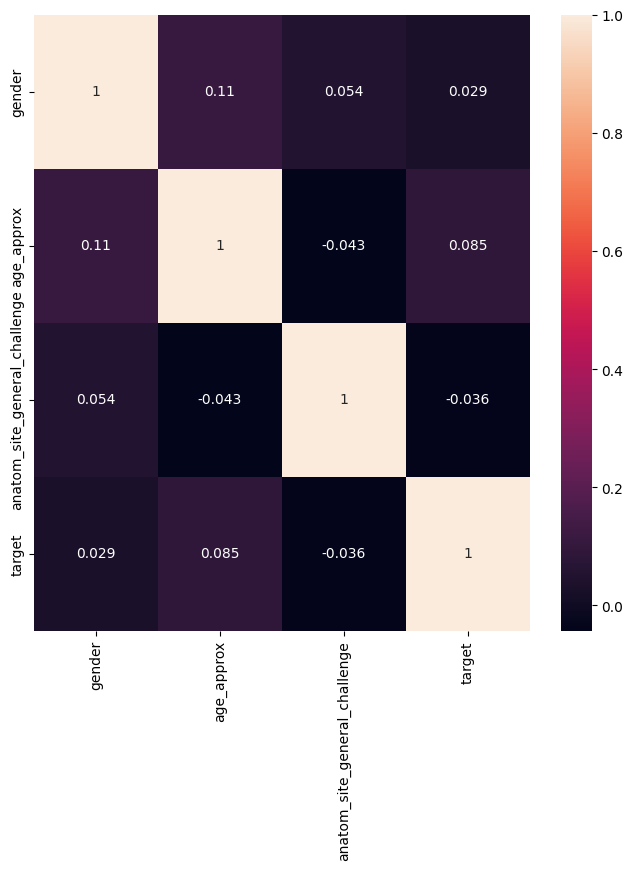

In [6]:
corr = train_df.drop("image_name", axis=1).corr()
plt.figure(figsize=(8, 8))
corr.style.background_gradient(cmap='coolwarm')
sns.heatmap(corr, annot=True)
plt.show()

#### Wo am Körper werden die meisten bösartigen Fälle festgestellt? -> Torso

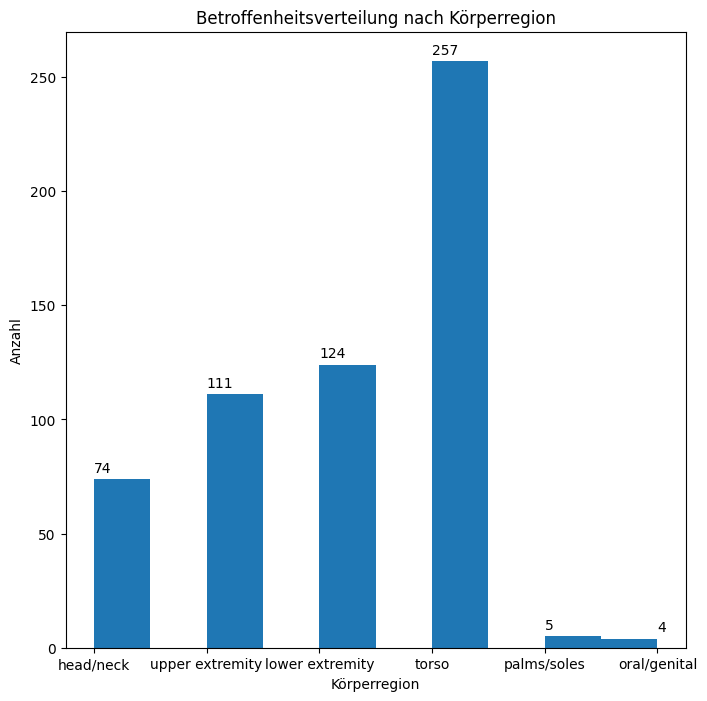

In [7]:
body_part = train_df[train_df["target"] == 1]["anatom_site_general_challenge"]
part_count = body_part.value_counts()
part_count = part_count.sort_index() # in richtige Reihenfolge für die Beschriftung bringen
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(body_part)
ax.set_xticks(list(anatom_site_map.values()))
ax.set_xticklabels(list(anatom_site_map.keys()))
ax.set_xlabel("Körperregion")
ax.set_ylabel("Anzahl")
for i, v in enumerate(part_count):
    ax.text(i, v+3, str(v))
ax.set_title("Betroffenheitsverteilung nach Körperregion")
plt.show()

#### Übersicht über die Imbalance im Dataset

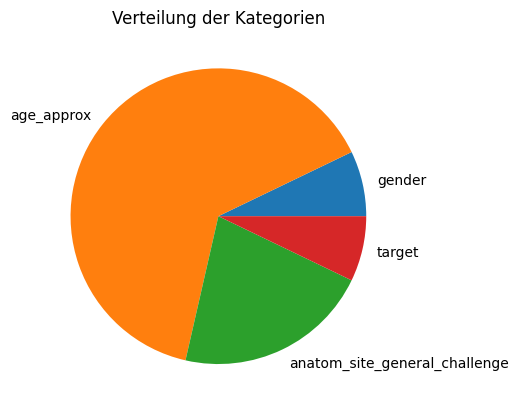

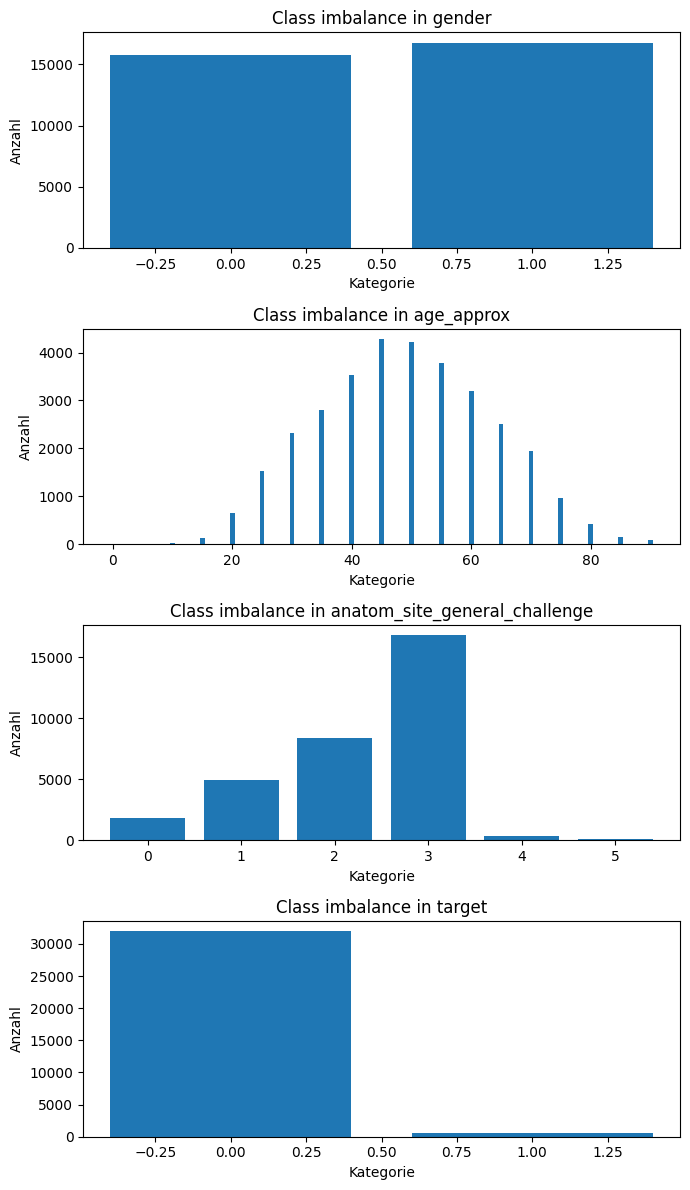

In [8]:
dist = []
for col in train_df.columns[1:]:
    dist.append(train_df[col].value_counts().unique().size)
plt.pie(dist, labels=train_df.columns[1:])
plt.title("Verteilung der Kategorien")
plt.show()

fig, axs = plt.subplots(len(train_df.columns[1:]), 1, figsize=(7, 3*len(train_df.columns[1:])))
for i, col in enumerate(train_df.columns[1:]):
    counts = train_df[col].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_xlabel('Kategorie')
    axs[i].set_ylabel('Anzahl')
    axs[i].set_title(f'Class imbalance in {col}')
plt.tight_layout()
plt.show()

In [9]:
# Die Imbalance der Zielvaibale "target" beheben
train_df = fix_imbalance(train_df)
train_df

,image_name,gender,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,1,45,0,0.0
1,ISIC_0015719,0,45,1,0.0
2,ISIC_0052212,0,50,2,0.0
3,ISIC_0068279,0,45,0,0.0
4,ISIC_0074268,0,55,1,0.0
...,...,...,...,...,...
63907,ISIC_8011058,0,30,2,1.0
63908,ISIC_5983500,0,85,1,1.0
63909,ISIC_2342769,0,65,0,1.0
63910,ISIC_9863642,0,35,0,1.0


#### Imbalance im Dataset nach Behebung

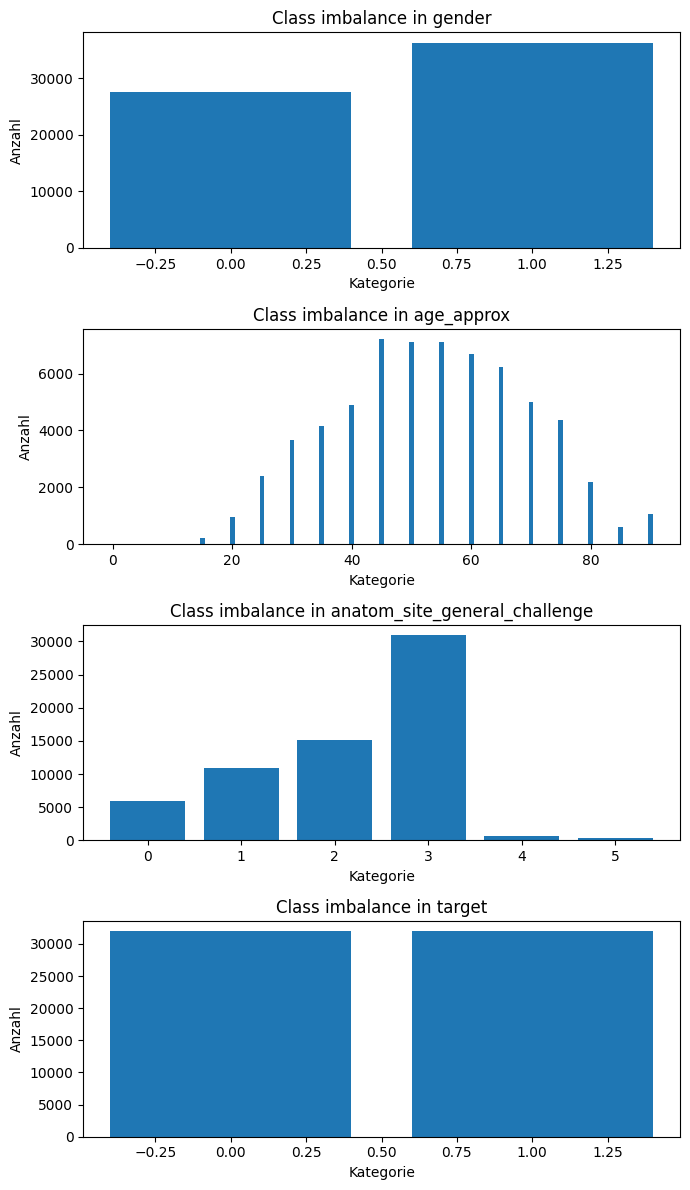

In [10]:
fig, axs = plt.subplots(len(train_df.columns[1:]), 1, figsize=(7, 3*len(train_df.columns[1:])))
for i, col in enumerate(train_df.columns[1:]):
    counts = train_df[col].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_xlabel('Kategorie')
    axs[i].set_ylabel('Anzahl')
    axs[i].set_title(f'Class imbalance in {col}')
plt.tight_layout()
plt.show()

## Zusammenfassung EDA
#### Plot 1: Die meisten bösartigen Befunde werden im Alter von ungefähr 60 Jahren gefunden
#### Plot 2 (Korrelation): Der stärkste Zusammenhang besteht zwischen age_approx und gender
#### Plot 3: am Torso sind mit großen Abstand zu "lower extremity" die meisten bösartigen Befunde

# Bildklassifikation

In [11]:
def load_image(file):
    img = PIL.Image.open(file).convert('RGB')
    return img, train_df[train_df["image_name"] == file.replace("./jpeg/train/", "").replace(".jpg", "")]["target"].values[0] # Bild und Label zurückgeben

all_images = []
all_labels = []
num_img_to_load = min(500, len(train_df["image_name"])) # verhindern, dass mehr Bilder geladen werden als es Einträge in train_df gibt

for val in train_df["image_name"].head(num_img_to_load).apply(lambda x: f"./jpeg/train/{x}.jpg"):
    i, l = load_image(val)
    all_images.append(i)
    all_labels.append(l)

print(f"finished loading {num_img_to_load} images")

class Brain(torch.nn.Module):
    def __init__(self, hidden_size: int, dropout: int):
        super(Brain, self).__init__()
        self.backbone = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.DEFAULT) # resnet18 mit vortrainierten Gewichten laden
        self.backbone.fc = torch.nn.Sequential(
            torch.nn.Linear(512, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout/100),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Sigmoid()
        )
        self.freeze()

    def freeze(self):
        for param in self.backbone.parameters(): # resnet18-Schichten nicht "lernen lassen"
            param.requires_grad = False
        for param in self.backbone.fc.parameters(): # die selbst angelegten Schichten sollen lernen
            param.requires_grad = True

    def unfreeze(self):
        for param in self.backbone.parameters(): # Alle Schichten zum lernen freigeben
            param.requires_grad = True
    
    def forward(self, x):
        return self.backbone(x)

class ImageDataset_Train(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        label = torch.tensor(self.labels[i], dtype=torch.float32)
        img = self.images[i]
        img = self.transform(img)
        return img, label
    
class ImageDataset_Test(torch.utils.data.Dataset):
    def __init__(self, imgs, transform):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = self.imgs[i]
        img = self.transform(img)
        return img
    
class ImageDataset_Validation(torch.utils.data.Dataset):
    def __init__(self, imgs, labels, transform):
        self.imgs = imgs
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        label = torch.tensor(self.labels[i], dtype=torch.float32)
        img = self.imgs[i]
        img = self.transform(img)
        return img, label
    
train_transformer = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.03),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Farbwerte der Bilder auf dieselben Werte bringen, wie die, mit denen resnets trainiert wurden
])

test_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

finished loading 500 Images


In [12]:
def get_accuracy(model, dataset, device):
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)   
            y_pred=model(xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item() # die Anzahl der true-Ergebnisse aus dem Vergleich summieren und das item aus dem Tensor holen
            total+=len(yb)
    return correct/total

def get_accuracy_hy(model, dataset, device):
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, imgb, yb in loader:
            xb, imgb, yb = xb.to(device), imgb.to(device), yb.to(device)   
            y_pred=model(imgb, xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item()
            total+=len(yb)
    return correct/total

def get_f1_score(model, dataset, device):
    loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb)
            y_pred = torch.argmax(y_pred, dim=1)
            all_preds.extend(y_pred.cpu().numpy()) # Variable zur CPU senden und dann in ein numpy-array umwandeln
            all_labels.extend(yb.cpu().numpy())
    return f1_score(all_labels, all_preds, average='weighted') # weighted: score für jede Spalte. Dann wird der gewichtete (je nachdem wie viele richtig waren) Durchschnitt gebildet

def get_f1_score_hy(model, dataset, device):
    loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, im, yb in loader:
            xb, im, yb = xb.to(device), im.to(device), yb.to(device)
            y_pred = model(im, xb)
            y_pred = torch.argmax(y_pred, dim=1)
            all_preds.extend(y_pred.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    return f1_score(all_labels, all_preds, average='weighted')

Epoch [1/30], Loss: 0.25834858417510986, Accuracy: 0
Epoch [2/30], Loss: 0.24882379174232483, Accuracy: 0
Epoch [3/30], Loss: 0.27073436975479126, Accuracy: 0
Epoch [4/30], Loss: 0.26544177532196045, Accuracy: 0
Epoch [5/30], Loss: 0.25755026936531067, Accuracy: 0
Epoch [6/30], Loss: 0.2596871256828308, Accuracy: 0
Epoch [7/30], Loss: 0.2532930374145508, Accuracy: 0
Epoch [8/30], Loss: 0.2593342959880829, Accuracy: 0
Epoch [9/30], Loss: 0.25839361548423767, Accuracy: 0
Epoch [10/30], Loss: 0.2492275983095169, Accuracy: 0
Epoch [11/30], Loss: 0.2521820366382599, Accuracy: 0
Epoch [12/30], Loss: 0.2536497116088867, Accuracy: 0
Epoch [13/30], Loss: 0.25113242864608765, Accuracy: 0
Epoch [14/30], Loss: 0.2489115595817566, Accuracy: 0
Epoch [15/30], Loss: 0.25000491738319397, Accuracy: 0
Epoch [16/30], Loss: 0.2605649530887604, Accuracy: 0
Epoch [17/30], Loss: 0.2684115171432495, Accuracy: 0
Epoch [18/30], Loss: 0.24833732843399048, Accuracy: 0
Epoch [19/30], Loss: 0.27226561307907104, Accu

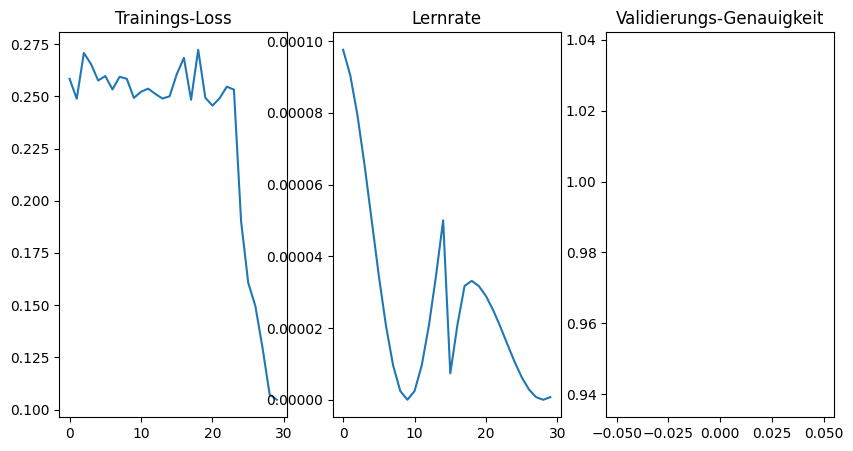

Model: 
	Accuracy: 0.9878048780487805
	F1-Score: 0.9817447254227144


In [13]:
lr = 0.0001
epochs = 30
unfreeze_epoch = 15
num_imgs = 10
test_size = 0.2
eval_steps = int(epochs - (epochs * 0.2)) # nach 80% der Epochen die Accuracy berechnen
steps = 0
bs = 64

all_names = list(train_df["image_name"])
train_df = train_df.drop("image_name", axis=1)
train_images = all_images[:num_imgs - int(num_imgs * test_size)]
train_labels = all_labels[:num_imgs - int(num_imgs * test_size)]

test_images = all_images[int(num_imgs * (1-test_size)):]
test_labels = all_labels[int(num_imgs * (1-test_size)):]

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

brain = Brain(1000, 40).to(device)
train_ds = ImageDataset_Train(train_images, train_labels, train_transformer)
test_ds = ImageDataset_Test(test_images, test_transformer)
validation_ds = ImageDataset_Validation(test_images, test_labels, test_transformer)
optimizer = torch.optim.AdamW(brain.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=False)
loss_fn = torch.nn.MSELoss().to(device) # CrossEntropyLoss hat Probleme verursacht

data = {"train": [], "test": [], "lr": [], "acc": []}
acc = 0
for epoch in range(epochs):
    if epoch == unfreeze_epoch:
        brain.unfreeze()
        optimizer=torch.optim.AdamW(brain.parameters(), lr=scheduler.get_last_lr()[0], weight_decay=0.0001)
        scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr/3, steps_per_epoch=len(train_dataloader), epochs=(epochs-epoch)*len(train_dataloader))
    for xb, yb in train_dataloader:
        steps+=1
        yb = yb.long()
        xb = xb.to(device)
        yb = yb.float().to(device)
        y_hat = brain(xb)
        loss = loss_fn(y_hat, yb)
        loss.backward()
        optimizer.step()
        data["train"].append(loss.item())
        scheduler.step()
        optimizer.zero_grad()
        data["lr"].append(scheduler.get_last_lr())
        if steps%eval_steps == 0:
            acc = get_accuracy(brain, validation_ds, device)
            data["acc"].append(acc)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Accuracy: {acc}")

torch.save(brain.state_dict(), "model_2k.pt")

fig, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].plot(data["train"])
ax[0].set_title('Trainings-Loss')
ax[1].plot(data["lr"])
ax[1].set_title('Lernrate')
ax[2].plot(data["acc"])
ax[2].set_title('Validierungs-Genauigkeit')

plt.show()

print(f"Model: \n\tAccuracy: {acc}\n\tF1-Score: {get_f1_score(brain, validation_ds, device)}")

# Klassifikation mit Bild- und Tabellendaten

In [18]:
class HybridModel(torch.nn.Module):
    def __init__(self, num_table_columns: int, submit: bool = False):
        super(HybridModel, self).__init__()
        hidden_size = 1000
        dropout = 30
        
        self.submit = submit
        self.backbone_cnn = torchvision.models.resnet34(pretrained=True)
        self.backbone_cnn.fc = torch.nn.Linear(self.backbone_cnn.fc.in_features, 512)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(num_table_columns +  512, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout/100),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Linear(hidden_size, hidden_size+100),
            torch.nn.ReLU(),
            torch.nn.Dropout((dropout/100)/2),
            torch.nn.BatchNorm1d(hidden_size+100),
            torch.nn.Linear(hidden_size+100, 1),
            torch.nn.Sigmoid()
        )
        self.freeze()

    def freeze(self):
        for param in self.backbone_cnn.parameters():
            param.requires_grad = False
        for param in self.backbone_cnn.fc.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.backbone_cnn.parameters():
            param.requires_grad = True

    def forward(self, img, tab):
        if len(img.shape) == 3:
            img = img.unsqueeze(0) # simuliert eine batch-Dimension bei einem einzigen Bild
        if len(tab.shape) == 1:
            tab = tab.unsqueeze(0) # siehe oben
        imgf = self.backbone_cnn(img)
        if self.submit: # entscheidung wegen shape-mismatch
            imgf = imgf.view(1, -1) # Bild wird "flat" -> shape(1, BS * Kanäle * Höhe * Breite)
            combi = torch.cat([imgf, tab], dim=1)
        else:
            combi = torch.cat([imgf, tab], dim=1)
        return self.fc(combi)

    
class HybridDataset_Train(torch.utils.data.Dataset):
    def __init__(self, table, images, labels, transformer):
        self.table = table
        self.images = images
        self.labels = labels
        self.transformer = transformer
        self.len = len(table[0])

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        row = torch.tensor(self.table[i], dtype=torch.float32)
        img = self.images[i]
        img = self.transformer(img)
        label = torch.tensor(self.labels[i], dtype=torch.float32)
        return row, img, label
    
class HybridDataset_Test(torch.utils.data.Dataset):
    def __init__(self, table, images, transformer):
        self.table = table
        self.images = images
        self.transformer = transformer
        self.len = len(table[0])

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        row = torch.tensor(self.table[i], dtype=torch.float32)
        img = self.images[i]
        img = self.transformer(img)
        return row, img
    
class HybridDataset_Validation(torch.utils.data.Dataset):
    def __init__(self, table, images, labels, transformer):
        self.table = table
        self.images = images
        self.labels = labels
        self.transformer = transformer
        self.len = len(table[0])

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        row = torch.tensor(self.table[i], dtype=torch.float32)
        label = torch.tensor(self.labels[i], dtype=torch.float32)
        img = self.images[i]
        img = self.transformer(img)
        return row, img, label

Epoch [1/30], Loss: 0.2587937116622925, Accuracy: 0
Epoch [2/30], Loss: 0.27108925580978394, Accuracy: 0
Epoch [3/30], Loss: 0.2602618336677551, Accuracy: 0
Epoch [4/30], Loss: 0.27350151538848877, Accuracy: 0
Epoch [5/30], Loss: 0.2742868959903717, Accuracy: 0
Epoch [6/30], Loss: 0.25850340723991394, Accuracy: 0
Epoch [7/30], Loss: 0.27719244360923767, Accuracy: 0
Epoch [8/30], Loss: 0.2424272894859314, Accuracy: 0
Epoch [9/30], Loss: 0.2885262370109558, Accuracy: 0
Epoch [10/30], Loss: 0.23669585585594177, Accuracy: 0
Epoch [11/30], Loss: 0.2462843358516693, Accuracy: 0
Epoch [12/30], Loss: 0.23344381153583527, Accuracy: 0
Epoch [13/30], Loss: 0.25679582357406616, Accuracy: 0
Epoch [14/30], Loss: 0.24235615134239197, Accuracy: 0
Epoch [15/30], Loss: 0.24400947988033295, Accuracy: 0
Epoch [16/30], Loss: 0.2385973334312439, Accuracy: 0
Epoch [17/30], Loss: 0.2599213719367981, Accuracy: 1.0
Epoch [18/30], Loss: 0.1577197015285492, Accuracy: 1.0
Epoch [19/30], Loss: 0.019967656582593918,

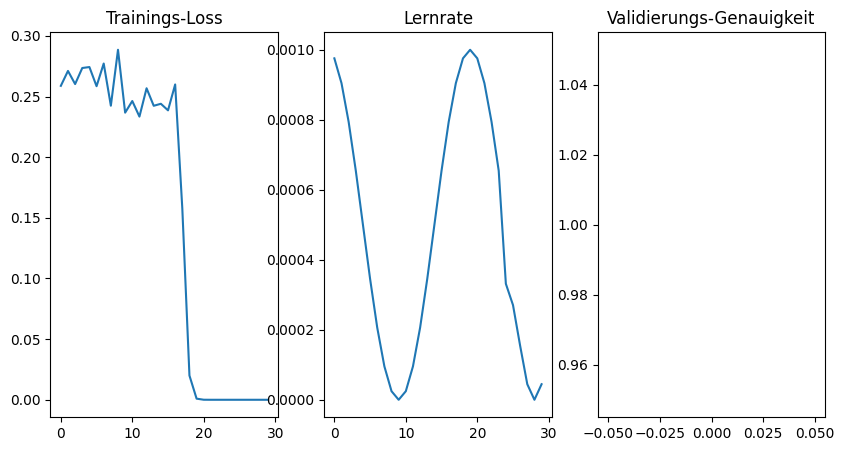

In [19]:
hy_epochs = 30
hy_lr = 0.001
hy_bs = 64
hy_unfreeze_epoch = int(hy_epochs - (hy_epochs * 0.2))
acc = 0
train_df_cp = train_df.copy()
df_vals = train_df_cp.values.tolist()
hy_test_size = 0.2

hy_train_table = df_vals[:num_imgs - int(num_imgs * hy_test_size)]
hy_test_table = df_vals[num_imgs - int(num_imgs * hy_test_size): num_imgs + (num_imgs - int(num_imgs * hy_test_size))*num_imgs + num_imgs]

hy_train_imgs = all_images[:num_imgs - int(num_imgs * hy_test_size)]
hy_test_imgs = all_images[num_imgs - int(num_imgs * hy_test_size):]

hy_train_labels = all_labels[:num_imgs - int(num_imgs * hy_test_size)]
hy_test_labels = all_labels[num_imgs - int(num_imgs * hy_test_size):]

hy_brain = HybridModel(len(hy_train_table[0])).to(device)
hy_train_ds = HybridDataset_Train(hy_train_table, hy_train_imgs, hy_train_labels, train_transformer)
hy_test_ds = HybridDataset_Test(hy_test_table, hy_test_imgs, test_transformer)
hy_val_ds = HybridDataset_Validation(hy_test_table, hy_test_imgs, hy_test_labels, test_transformer)

hy_optimizer = torch.optim.AdamW(hy_brain.parameters(), lr=hy_lr)
hy_train_dataloader = torch.utils.data.DataLoader(hy_train_ds, batch_size=hy_bs, shuffle=True)
hy_test_dataloader = torch.utils.data.DataLoader(hy_test_ds, batch_size=hy_bs, shuffle=False)
hy_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(hy_optimizer, T_max=10)
hy_loss_fn = torch.nn.MSELoss().to(device)

hy_data = {"train": [], "test": [], "lr": [], "acc": []}

for epoch in range(hy_epochs):
    if epoch == hy_unfreeze_epoch:
        hy_brain.unfreeze()
        hy_optimizer=torch.optim.AdamW(hy_brain.parameters(), lr=hy_scheduler.get_last_lr()[0], weight_decay=0.0001)
        hy_scheduler=torch.optim.lr_scheduler.OneCycleLR(hy_optimizer, max_lr=hy_lr/3, steps_per_epoch=len(hy_train_dataloader), epochs=(hy_epochs-epoch)*len(hy_train_dataloader))
    for xb, imgb, yb in hy_train_dataloader:
        steps+=1
        yb = yb.long()
        xb = xb.to(device)
        yb = yb.float().to(device)
        imgb = imgb.to(device)
        y_hat = hy_brain(imgb, xb)
        loss = hy_loss_fn(y_hat, yb)
        loss.backward()
        hy_optimizer.step()
        hy_data["train"].append(loss.item())
        hy_scheduler.step()
        hy_optimizer.zero_grad()
        hy_data["lr"].append(hy_scheduler.get_last_lr())
        if steps%eval_steps == 0:
            acc = get_accuracy_hy(hy_brain, hy_val_ds, device)
            hy_data["acc"].append(acc)
    print(f"Epoch [{epoch+1}/{hy_epochs}], Loss: {loss.item()}, Accuracy: {acc}")

torch.save(hy_brain.state_dict(), "hybrid_model_2k.pt")

fig, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].plot(hy_data["train"])
ax[0].set_title('Trainings-Loss')
ax[1].plot(hy_data["lr"])
ax[1].set_title('Lernrate')
ax[2].plot(hy_data["acc"])
ax[2].set_title('Validierungs-Genauigkeit')

plt.show()

In [20]:
print(f"Model: \n\tAccuracy: {acc}\n\tF1-Score: {get_f1_score_hy(hy_brain, hy_val_ds, device)}")

Model: 
	Accuracy: 1.0
	F1-Score: 1.0


# Die Submissions erstellen

In [21]:
class HybridDataset_Prediction(torch.utils.data.Dataset):
    def __init__(self, table, images, transformer): # hier images als Dateinamen gegeben wegen Speicherproblemen
        self.table = table
        self.images = images
        self.transformer = transformer
        self.len = len(table)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        row = torch.tensor(self.table[i][1:], dtype=torch.float32)
        row = torch.cat((row, torch.tensor([1.0])), dim=0)
        img_n = self.images[i]
        img = PIL.Image.open(f"./jpeg/test/{img_n}.jpg").convert('RGB')
        img = self.transformer(img)
        return row, img

final_df, anatom_site_map, _ = load_and_transform("test.csv", export = True)
final_table = final_df.copy()
final_table = final_table.values.tolist()
brain = Brain(1000, 40)
brain.to(device)
brain.eval()
hy_brain = HybridModel(len(hy_train_table[0]), submit=True)
hy_brain.to(device)
hy_brain.eval()
final_images = final_df["image_name"].values.tolist()

final_ds = HybridDataset_Prediction(final_table, final_images, test_transformer)

img_model_prediction = []
hybrid_model_prediction = []
for i in range(len(final_ds)):
    row, img = final_ds[i]
    img = img.to(device)
    row = row.to(device)
    y_hat_def = float(torch.argmax(brain(img.unsqueeze(0)))) # unsqueeze(0) fügt an 0ter STelle eine Dimesion hinzu (1, Breite, Höhe)
    y_hat_hy = float(torch.argmax(hy_brain(img, row)))
    img_model_prediction.append(y_hat_def)
    hybrid_model_prediction.append(y_hat_hy)

sub_df1 = pd.DataFrame({"image_name": final_df["image_name"], "target": img_model_prediction})
sub_df2 = pd.DataFrame({"image_name": final_df["image_name"], "target": hybrid_model_prediction})
sub_df1.to_csv("submission_img_model.csv", index=False)
sub_df2.to_csv("submission_hybrid_model.csv", index=False)

## Vorgehen
* Daten bereinigt und aussortiert (Nan-Werte entfernen/füllen, Spalten entfernen, Datentypen anpassen)
* EDA: versucht Auffälligkeiten erkennbar zu machen, Imbalance dargestellt und behoben
* Bilder laden
* Klassen und Funktionen für die Bildklassifikation bauen
* Bildmodell trainieren
* Klassen und Funktionen für die hybride Klassifikation bauen
* Hybridmodell trainieren
* Beide Modelle die predictions machen lassen und in je eine csv-Datei speichern


## Probleme und Sackgassen bei diesem Projekt
* Technische Limitierungen: RAM-Größe, GPU-Geschwindigkeit
* "Problem", dass einige Spalten nicht in beiden Datasets vorhanden sind (z.B. diagnosis)
* häufiges type/shape-mismatch (durch das hybride Dataset)
* Parallel konnte nicht zum laden der Bilder verwendet werden -> PC abgestürzt

## Kaggle Ergebnis

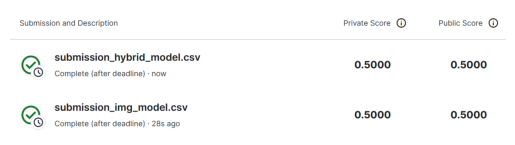

In [22]:
img = mpimg.imread('res.png') 
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()